In [1]:
import pynbody
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pynbody import units
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from scipy import stats
from scipy import constants
import pynbody.filt as f
import matplotlib.gridspec as gd
import pickle


In [2]:
pynbody.config["number_of_threads"] = 2
pynbody.config["sph"]["Kernel"] = 'CubicSpline'
pynbody.config['sph']['smooth-particles'] = 100

In [3]:
s = pynbody.load('../Documents/Bachelorthesis/simulations/g8.26/g8.26e11.01024')
h = s.halos()
h1 = h[1]
s.physical_units()
pynbody.analysis.angmom.faceon(h1)

In [4]:
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
gal = h1[disk]

In [5]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_W(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', pynbody.config['sph']['smooth-particles'], 'WendlandC2')

    return rho


@pynbody.snapshot.SimSnap.stable_derived_quantity
def rho_CS(self):
    pynbody.sph.build_tree_or_trees(self)


    rho = pynbody.array.SimArray(
        np.empty(len(self['pos'])), self['mass'].units / self['pos'].units ** 3,
        dtype=self['pos'].dtype)



    self.kdtree.set_array_ref('smooth',pynbody.sph._get_smooth_array_ensuring_compatibility(self))
    self.kdtree.set_array_ref('mass',self['mass'])
    self.kdtree.set_array_ref('rho',rho)

    self.kdtree.populate('rho', pynbody.config['sph']['smooth-particles'], 'CubicSpline')

    return rho

In [6]:
@pynbody.snapshot.SimSnap.stable_derived_quantity
def mass_sph(self):
    import logging
    logger = logging.getLogger('pynbody.sph')

    pynbody.sph.build_tree_or_trees(self)

    logger.info('Calculating sph mean')
    
    mass_sph = self.kdtree.sph_mean(self['mass'], nsmooth=pynbody.config['sph']['smooth-particles'])
    

    return mass_sph

@pynbody.snapshot.SimSnap.derived_quantity
def v_curl2(self):
    """Squared velocity"""
    return (self['v_curl'] ** 2).sum(axis=1)

# mass weighted 2d histograms

def mw_hist2(fam, key, b):
    hist, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam[key]*fam['mass'], bins=b, range=((-50,50),(-50,50)))
    mass, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam['mass'], bins=b, range=((-50,50),(-50,50)))
    return hist/mass

def mw_hist(fam, array, b):
    hist, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=array*fam['mass'], bins=b, range=((-50,50),(-50,50)))
    mass, xbin, ybin = np.histogram2d(fam['x'],fam['y'],weights=fam['mass'], bins=b, range=((-50,50),(-50,50)))
    return hist/mass

In [7]:
#rho_CS_25 = [0.00410579 0.02528108 0.06515558 ... 0.06111136 0.02801257 0.01519657]
#rho_CS_50 = [0.00390987 0.02469091 0.06087668 ... 0.06229264 0.02547941 0.0148165 ]
#rho_CS_100 = [0.00414312 0.02647664 0.05870217 ... 0.06701439 0.02762156 0.01603326]
#rho_W_25 = [0.00458684 0.02763152 0.06920677 ... 0.06517881 0.03197577 0.01677227]
#rho_W_50 = [0.00417549 0.02533851 0.06294318 ... 0.06326283 0.02665569 0.0154375 ]
#rho_W_100 = [0.00410087 0.02614862 0.05962141 ... 0.06603882 0.02715642 0.01574668] 

In [8]:
'''
#calculations
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
gal = h1[disk]
disk = f.LowPass('r', '72 kpc') & f.BandPass('z', '-0.5 kpc', '0.5 kpc')
(10*1.673*10**(-27)*units.kg/units.cm**3).ratio(units.Msol/units.kpc**3)
#sf = f.HighPass('rho', '247133368.31459114 Msol kpc^-3') & f.LowPass('temp', '30000 K')
gal = h1[disk]
gal.g['rho'] = gal.g['rho_CS']
#gal.g['rho'] = gal.g['rho_W']
gal.g['v_div']
s.s['v_div']
gal.g['v_curl']
s.s['v_curl']
gal.g['mass_sph']
s.s['mass_sph']
gal.g['v_curl2']
s.s['v_curl2']
m_part = gal.g['mass']
m_kern = gal.g['rho']*4/3*np.pi*gal.g['smooth']**3 
m_sph = gal.g['mass_sph']

gal.g['radius'] = gal.g['smooth'].in_units('m') #in units m
gal.g['radius_2'] = gal.g['radius']
gal.g['radius_2'] = (m_sph.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)
gal.g['radius_3'] = gal.g['radius']
gal.g['radius_3'] = (m_part.in_units('kg')/gal.g['rho']*((3.0857e+19)**3/(2e+30))*3/(4*np.pi))**(1/3)

gal.g['alpha'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_2'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_2']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_sph.in_units('kg'))).in_units(1)
gal.g['alpha_3'] = (5*(gal.g['v_disp'].in_units('m s**-1'))**2*gal.g['radius_3']/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*m_part.in_units('kg'))).in_units(1)
gal.g['alpha_4'] = 1/4*(np.abs(gal.g['v_div'].in_units('s**-1'))**2+np.sqrt(gal.g['v_curl2'].in_units('s**-2'))**2)/(constants.G*units.m**3*units.kg**-1*gal.g['rho'].in_units('kg m**-3')).in_units(1)
#gal.g['alpha_5'] = # mit Ekin und Epot

b = 2.02
gal.g['efficiency_vdisp'] = np.exp(-b*gal.g['alpha_3']**(1/2))
gal.g['efficiency_Hopkins'] = np.exp(-b*gal.g['alpha_4']**(1/2))

low_alpha = f.LowPass('alpha', '100')
low_alpha_2 = f.LowPass('alpha_2', '100')
low_alpha_3 = f.LowPass('alpha_3', '100')
low_alpha_4 = f.LowPass('alpha_4', '100')

#gal_low_alpha = gal.g[low_alpha]
#gal_low_alpha_2 = gal.g[low_alpha_2]
#gal_low_alpha_3 = gal.g[low_alpha_3]
#gal_low_alpha_4 = gal.g[low_alpha_4]
'''

In [9]:
'''
# pickling
with open('CS_100.pkl', 'wb') as CS_100_pickle:
    pickle.dump(gal.g['rho'], CS_100_pickle)
    pickle.dump(gal.g['v_div'], CS_100_pickle)
    pickle.dump(gal.g['v_curl'], CS_100_pickle)
    pickle.dump(gal.g['mass_sph'], CS_100_pickle)
    pickle.dump(gal.g['v_curl2'], CS_100_pickle)
    pickle.dump(gal.g['v_disp'], CS_100_pickle)
    pickle.dump(gal.g['mass'], CS_100_pickle)
    pickle.dump(gal.g['smooth'], CS_100_pickle) 
    pickle.dump(gal.g['radius'], CS_100_pickle)
    pickle.dump(gal.g['radius_2'], CS_100_pickle)
    pickle.dump(gal.g['radius_3'], CS_100_pickle)   
    pickle.dump(gal.g['alpha'], CS_100_pickle)
    pickle.dump(gal.g['alpha_2'], CS_100_pickle)
    pickle.dump(gal.g['alpha_3'], CS_100_pickle)
    pickle.dump(gal.g['alpha_4'], CS_100_pickle)
    pickle.dump(gal.g['efficiency_vdisp'], CS_100_pickle)
    pickle.dump(gal.g['efficiency_Hopkins'], CS_100_pickle)
'''

In [12]:
# unpickling CS_25
with open('CS_25.pkl', 'rb') as CS_25_pickle:
    rho_CS_25 = pickle.load(CS_25_pickle)
    vdiv_CS_25 = pickle.load(CS_25_pickle)
    vcurl_CS_25 = pickle.load(CS_25_pickle)
    sphmass_CS_25 = pickle.load(CS_25_pickle)
    vcurl2_CS_25 = pickle.load(CS_25_pickle)
    vdisp_CS_25 = pickle.load(CS_25_pickle)
    mass_CS_25 = pickle.load(CS_25_pickle)
    smooth_CS_25 = pickle.load(CS_25_pickle) 
    radius_CS_25 = pickle.load(CS_25_pickle)
    radius2_CS_25 = pickle.load(CS_25_pickle)
    radius3_CS_25 = pickle.load(CS_25_pickle)   
    alpha_CS_25 = pickle.load(CS_25_pickle)
    alpha2_CS_25 = pickle.load(CS_25_pickle)
    alpha3_CS_25 = pickle.load(CS_25_pickle)
    alpha4_CS_25 = pickle.load(CS_25_pickle)
    eff_vdisp_CS_25 = pickle.load(CS_25_pickle)
    eff_Hop_CS_25 = pickle.load(CS_25_pickle)


In [14]:

# unpickling
with open('CS_50.pkl', 'rb') as CS_50_pickle:
    rho_CS_50 = pickle.load(CS_50_pickle)
    vdiv_CS_50 = pickle.load(CS_50_pickle)
    vcurl_CS_50 = pickle.load(CS_50_pickle)
    sphmass_CS_50 = pickle.load(CS_50_pickle)
    vcurl2_CS_50 = pickle.load(CS_50_pickle)
    vdisp_CS_50 = pickle.load(CS_50_pickle)
    mass_CS_50 = pickle.load(CS_50_pickle)
    smooth_CS_50 = pickle.load(CS_50_pickle) 
    radius_CS_50 = pickle.load(CS_50_pickle)
    radius2_CS_50 = pickle.load(CS_50_pickle)
    radius3_CS_50 = pickle.load(CS_50_pickle)   
    alpha_CS_50 = pickle.load(CS_50_pickle)
    alpha2_CS_50 = pickle.load(CS_50_pickle)
    alpha3_CS_50 = pickle.load(CS_50_pickle)
    alpha4_CS_50 = pickle.load(CS_50_pickle)
    eff_vdisp_CS_50 = pickle.load(CS_50_pickle)
    eff_Hop_CS_50 = pickle.load(CS_50_pickle)


In [16]:

# unpickling
with open('CS_100.pkl', 'rb') as CS_100_pickle:
    rho_CS_100 = pickle.load(CS_100_pickle) 
    vdiv_CS_100 = pickle.load(CS_100_pickle)
    vcurl_CS_100 = pickle.load(CS_100_pickle)
    sphmass_CS_100 = pickle.load(CS_100_pickle)
    vcurl2_CS_100 = pickle.load(CS_100_pickle)
    vdisp_CS_100 = pickle.load(CS_100_pickle)
    mass_CS_100 = pickle.load(CS_100_pickle)
    smooth_CS_100 = pickle.load(CS_100_pickle) 
    radius_CS_100 = pickle.load(CS_100_pickle)
    radius2_CS_100 = pickle.load(CS_100_pickle)
    radius3_CS_100 = pickle.load(CS_100_pickle)   
    alpha_CS_100 = pickle.load(CS_100_pickle)
    alpha2_CS_100 = pickle.load(CS_100_pickle)
    alpha3_CS_100 = pickle.load(CS_100_pickle)
    alpha4_CS_100 = pickle.load(CS_100_pickle)
    eff_vdisp_CS_100 = pickle.load(CS_100_pickle)
    eff_Hop_CS_100 = pickle.load(CS_100_pickle)

In [18]:

# unpickling
with open('W_25.pkl', 'rb') as W_25_pickle:
    rho_W_25 = pickle.load(W_25_pickle) 
    vdiv_W_25 = pickle.load(W_25_pickle)
    vcurl_W_25 = pickle.load(W_25_pickle)
    sphmass_W_25 = pickle.load(W_25_pickle)
    vcurl2_W_25 = pickle.load(W_25_pickle)
    vdisp_W_25 = pickle.load(W_25_pickle)
    mass_W_25 = pickle.load(W_25_pickle)
    smooth_W_25 = pickle.load(W_25_pickle) 
    radius_W_25 = pickle.load(W_25_pickle)
    radius2_W_25 = pickle.load(W_25_pickle)
    radius3_W_25 = pickle.load(W_25_pickle)   
    alpha_W_25 = pickle.load(W_25_pickle)
    alpha2_W_25 = pickle.load(W_25_pickle)
    alpha3_W_25 = pickle.load(W_25_pickle)
    alpha4_W_25 = pickle.load(W_25_pickle)
    eff_vdisp_W_25 = pickle.load(W_25_pickle)
    eff_Hop_W_25 = pickle.load(W_25_pickle)

In [20]:

# unpickling
with open('W_50.pkl', 'rb') as W_50_pickle:
    rho_W_50 = pickle.load(W_50_pickle)
    vdiv_W_50 = pickle.load(W_50_pickle)
    vcurl_W_50 = pickle.load(W_50_pickle)
    sphmass_W_50 = pickle.load(W_50_pickle)
    vcurl2_W_50 = pickle.load(W_50_pickle)
    vdisp_W_50 = pickle.load(W_50_pickle)
    mass_W_50 = pickle.load(W_50_pickle)
    smooth_W_50 = pickle.load(W_50_pickle) 
    radius_W_50 = pickle.load(W_50_pickle)
    radius2_W_50 = pickle.load(W_50_pickle)
    radius3_W_50 = pickle.load(W_50_pickle)   
    alpha_W_50 = pickle.load(W_50_pickle)
    alpha2_W_50 = pickle.load(W_50_pickle)
    alpha3_W_50 = pickle.load(W_50_pickle)
    alpha4_W_50 = pickle.load(W_50_pickle)
    eff_vdisp_W_50 = pickle.load(W_50_pickle)
    eff_Hop_W_50 = pickle.load(W_50_pickle)
    

In [22]:

# unpickling
with open('W_100.pkl', 'rb') as W_100_pickle:
    rho_W_100 = pickle.load(W_100_pickle) 
    vdiv_W_100 = pickle.load(W_100_pickle)
    vcurl_W_100 = pickle.load(W_100_pickle)
    sphmass_W_100 = pickle.load(W_100_pickle)
    vcurl2_W_100 = pickle.load(W_100_pickle)
    vdisp_W_100 = pickle.load(W_100_pickle)
    mass_W_100 = pickle.load(W_100_pickle)
    smooth_W_100 = pickle.load(W_100_pickle) 
    radius_W_100 = pickle.load(W_100_pickle)
    radius2_W_100 = pickle.load(W_100_pickle)
    radius3_W_100 = pickle.load(W_100_pickle)   
    alpha_W_100 = pickle.load(W_100_pickle)
    alpha2_W_100 = pickle.load(W_100_pickle)
    alpha3_W_100 = pickle.load(W_100_pickle)
    alpha4_W_100 = pickle.load(W_100_pickle)
    eff_vdisp_W_100 = pickle.load(W_100_pickle)
    eff_Hop_W_100 = pickle.load(W_100_pickle)

In [24]:
print(rho_CS_25)
print(rho_CS_50)
print(rho_CS_100)
print(rho_W_25)
print(rho_W_50)
print(rho_W_100)

[36430472.56907646 55264511.48606121 14857918.9139252  ...
 87249992.04058419 73010283.71760382 76621217.23524253]
[30052465.8469368  56834899.15806207 11840345.26305064 ...
 78525993.49764588 73963433.46521772 66073631.03074075]
[27710588.88555671 56507165.95364997  9984643.5188241  ...
 70172041.04290375 74465062.88541879 62410301.89516456]
[40139667.88263775 57910944.6971043  16350095.36147095 ...
 94197071.02031444 74827827.50709301 85389970.28157909]
[31530559.03991144 57207110.27247659 12505516.18411783 ...
 81177162.22545688 74199268.82677269 69436245.58652507]
[28525115.83590598 56844667.28054758 10442060.31765283 ...
 72219757.69459683 74688786.03217565 63626645.74300915]


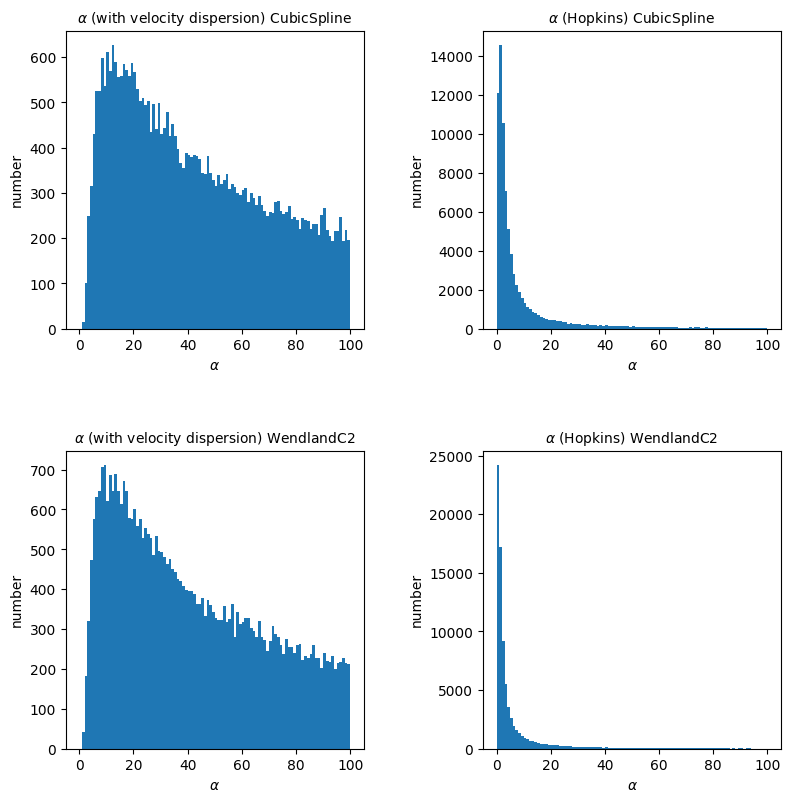

In [63]:
alpha = [alpha_CS_50, alpha2_CS_50, alpha3_CS_50, alpha4_CS_50, alpha_W_50, alpha2_W_50, alpha3_W_50, alpha4_W_50]
title = ['(Kernel)', '(sph particle)', '(with velocity dispersion)', '(Hopkins)']
fig = plt.figure(figsize = (20,10))
gs0 = gd.GridSpec(2, 4, figure=fig, wspace = 0.4)

for n in range(2,4):
    ax = fig.add_subplot(gs0[n])
    ax.hist(alpha[n], bins = 100, range = (0,100))
    ax.set_title(r'$\alpha$ ' + title[n] + ' CubicSpline', wrap = True, fontsize = 10)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('number')
    ax.set_aspect(1./ax.get_data_ratio())
       
for n in range(6,8): 
    ax = fig.add_subplot(gs0[n])
    ax.hist(alpha[n], bins = 100, range = (0,100))
    ax.set_title(r'$\alpha$ ' + title[n-4] + ' WendlandC2', wrap = True, fontsize = 10)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('number')
    ax.set_aspect(1./ax.get_data_ratio())

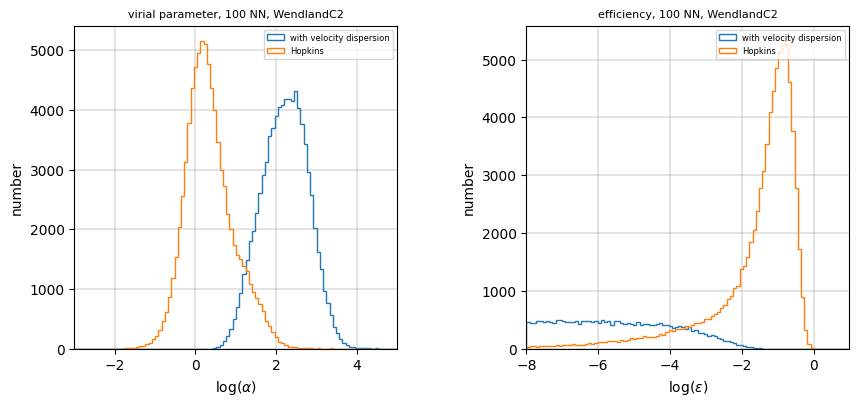

In [31]:
alpha_list = [np.log10(alpha3_W_100), np.log10(alpha4_W_100)]
eff_list = [np.log10(eff_vdisp_W_100), np.log10(eff_Hop_W_100)]
key_list = [alpha_list, eff_list]
range_list = [(-3, 5), (-8, 1)]
title = ['virial parameter, 100 NN, WendlandC2', 'efficiency, 100 NN, WendlandC2']
label = ['with velocity dispersion', 'Hopkins']
unit = ['log('+r'$\alpha$'+')', 'log('+r'$\epsilon$'+')']
fig = plt.figure(figsize = (10,5))
gs0 = gd.GridSpec(1, 2, figure=fig, wspace = 0.4)

for n in range(2):
    ax = fig.add_subplot(gs0[n])
    for i in range(2):
        ax.hist(key_list[n][i], bins = 100, label = label[i], range = range_list[n], histtype = 'step')
    ax.set_title(title[n], wrap = True, fontsize = 8)
    ax.set_xlabel(unit[n])
    ax.set_ylabel('number')
    ax.set_xlim(range_list[n])
    ax.set_aspect(1./ax.get_data_ratio())
    ax.grid(linewidth = 0.3, color = 'grey')
    ax.legend(fontsize = 6)

/tmp/ipykernel_30276/1507575172.py:4: RuntimeWarning: invalid value encountered in log10
  v_div_list = [np.log10(vdiv_CS_25), np.log10(vdiv_CS_50), np.log10(vdiv_CS_100), np.log10(vdiv_W_25), np.log10(vdiv_W_50), np.log10(vdiv_W_100)]
/tmp/ipykernel_30276/1507575172.py:8: RuntimeWarning: divide by zero encountered in log10
  eff_vdisp_list = [np.log10(eff_vdisp_CS_25), np.log10(eff_vdisp_CS_50), np.log10(eff_vdisp_CS_100), np.log10(eff_vdisp_W_25), np.log10(eff_vdisp_W_50), np.log10(eff_vdisp_W_100)]
/tmp/ipykernel_30276/1507575172.py:9: RuntimeWarning: divide by zero encountered in log10
  eff_Hop_list = [np.log10(eff_Hop_CS_25), np.log10(eff_Hop_CS_50), np.log10(eff_Hop_CS_100), np.log10(eff_Hop_W_25), np.log10(eff_Hop_W_50), np.log10(eff_Hop_W_100)]


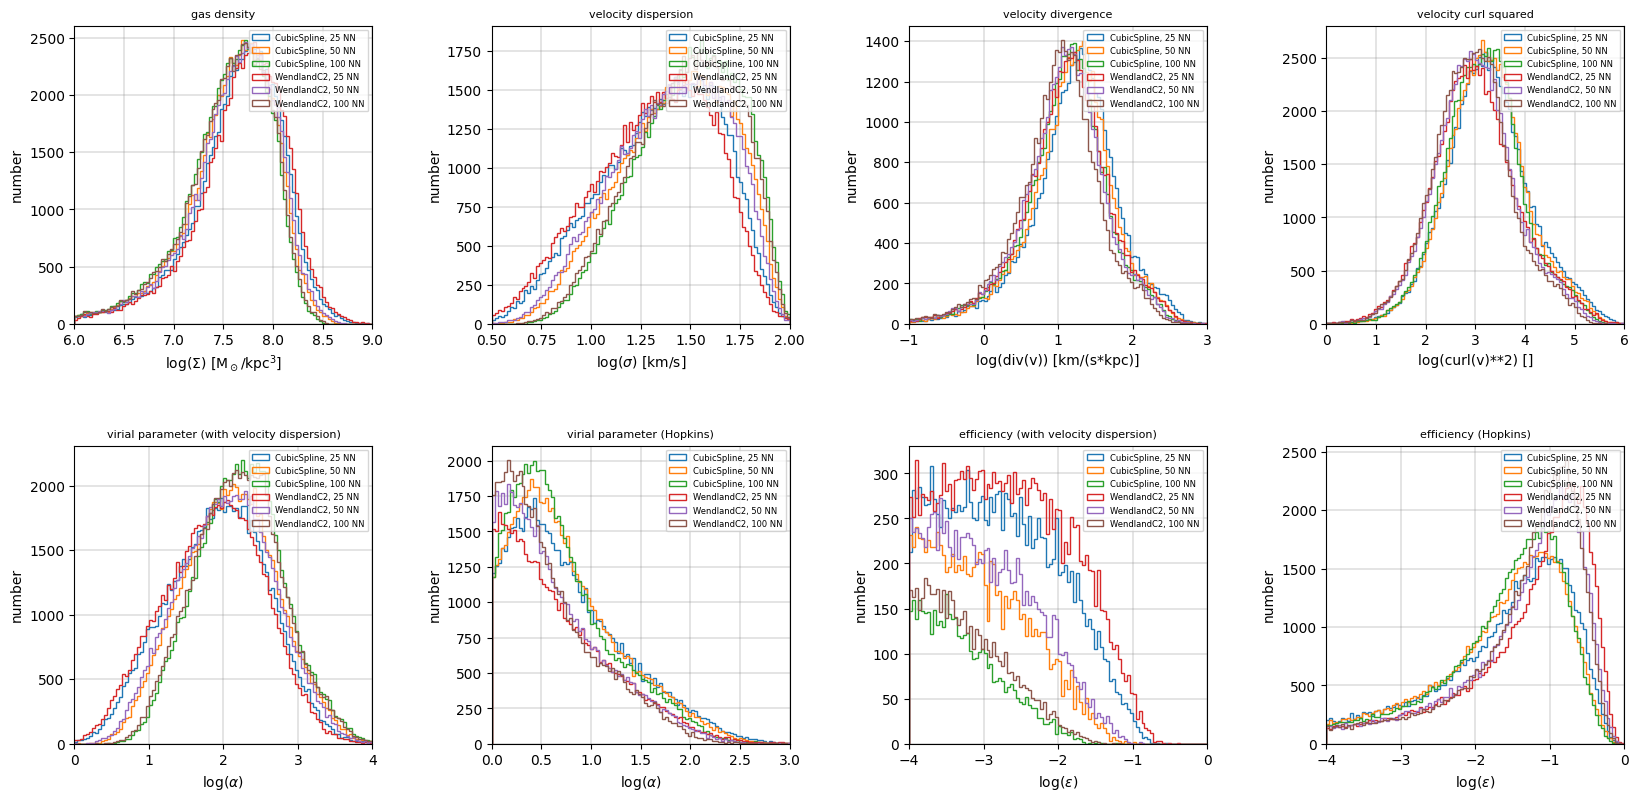

In [47]:
rho_list = [np.log10(rho_CS_25), np.log10(rho_CS_50), np.log10(rho_CS_100), np.log10(rho_W_25), np.log10(rho_W_50), np.log10(rho_W_100)]
#rho_list = [rho_CS_25, rho_CS_50, rho_CS_100, rho_W_25, rho_W_50, rho_W_100]
v_disp_list = [np.log10(vdisp_CS_25), np.log10(vdisp_CS_50), np.log10(vdisp_CS_100), np.log10(vdisp_W_25), np.log10(vdisp_W_50), np.log10(vdisp_W_100)]
v_div_list = [np.log10(vdiv_CS_25), np.log10(vdiv_CS_50), np.log10(vdiv_CS_100), np.log10(vdiv_W_25), np.log10(vdiv_W_50), np.log10(vdiv_W_100)]
v_curl2_list = [np.log10(vcurl2_CS_25), np.log10(vcurl2_CS_50), np.log10(vcurl2_CS_100), np.log10(vcurl2_W_25), np.log10(vcurl2_W_50), np.log10(vcurl2_W_100)]
alpha_2_list = [np.log10(alpha2_CS_25), np.log10(alpha2_CS_50), np.log10(alpha2_CS_100), np.log10(alpha2_W_25), np.log10(alpha2_W_50), np.log10(alpha2_W_100)]
alpha_4_list = [np.log10(alpha4_CS_25), np.log10(alpha4_CS_50), np.log10(alpha4_CS_100), np.log10(alpha4_W_25), np.log10(alpha4_W_50), np.log10(alpha4_W_100)]
eff_vdisp_list = [np.log10(eff_vdisp_CS_25), np.log10(eff_vdisp_CS_50), np.log10(eff_vdisp_CS_100), np.log10(eff_vdisp_W_25), np.log10(eff_vdisp_W_50), np.log10(eff_vdisp_W_100)]
eff_Hop_list = [np.log10(eff_Hop_CS_25), np.log10(eff_Hop_CS_50), np.log10(eff_Hop_CS_100), np.log10(eff_Hop_W_25), np.log10(eff_Hop_W_50), np.log10(eff_Hop_W_100)]
key_list = [rho_list, v_disp_list, v_div_list, v_curl2_list, alpha_2_list, alpha_4_list, eff_vdisp_list, eff_Hop_list]
range_list = [(6, 9), (0.5, 2), (-1, 3), (0, 6), (0, 4), (0, 3), (-4, 0), (-4, 0)]
title = ['gas density', 'velocity dispersion', 'velocity divergence', 'velocity curl squared', 'virial parameter (with velocity dispersion)', 'virial parameter (Hopkins)', 'efficiency (with velocity dispersion)', 'efficiency (Hopkins)']
unit = [r'log($\Sigma$) [M$_\odot$/kpc$^3$]', r'log($\sigma$) [km/s]', r'log(div(v)) [km/(s*kpc)]', r'log(curl(v)**2) []', 'log('+r'$\alpha$'+')', 'log('+r'$\alpha$'+')', 'log('+r'$\epsilon$'+')', 'log('+r'$\epsilon$'+')']
label = ['CubicSpline, 25 NN', 'CubicSpline, 50 NN', 'CubicSpline, 100 NN', 'WendlandC2, 25 NN', 'WendlandC2, 50 NN', 'WendlandC2, 100 NN']
fig = plt.figure(figsize = (20,10))
gs0 = gd.GridSpec(2, 4, figure=fig, wspace = 0.4)

for n in range(8):
    ax = fig.add_subplot(gs0[n])
    for i in range(6):
        ax.hist(key_list[n][i], bins = 100, label = label[i], range = range_list[n], histtype = 'step')
        
    ax.set_title(title[n], wrap = True, fontsize = 8)
    ax.set_xlabel(unit[n])
    ax.set_ylabel('number')
    ax.set_xlim(range_list[n])
    ax.set_aspect(1./ax.get_data_ratio())
    ax.grid(linewidth = 0.3, color = 'grey')
    ax.legend(fontsize = 6)

/tmp/ipykernel_27228/3244665734.py:4: RuntimeWarning: invalid value encountered in log10
  v_div_list = [np.log10(vdiv_CS_25), np.log10(vdiv_CS_50), np.log10(vdiv_CS_100), np.log10(vdiv_W_25), np.log10(vdiv_W_50), np.log10(vdiv_W_100)]


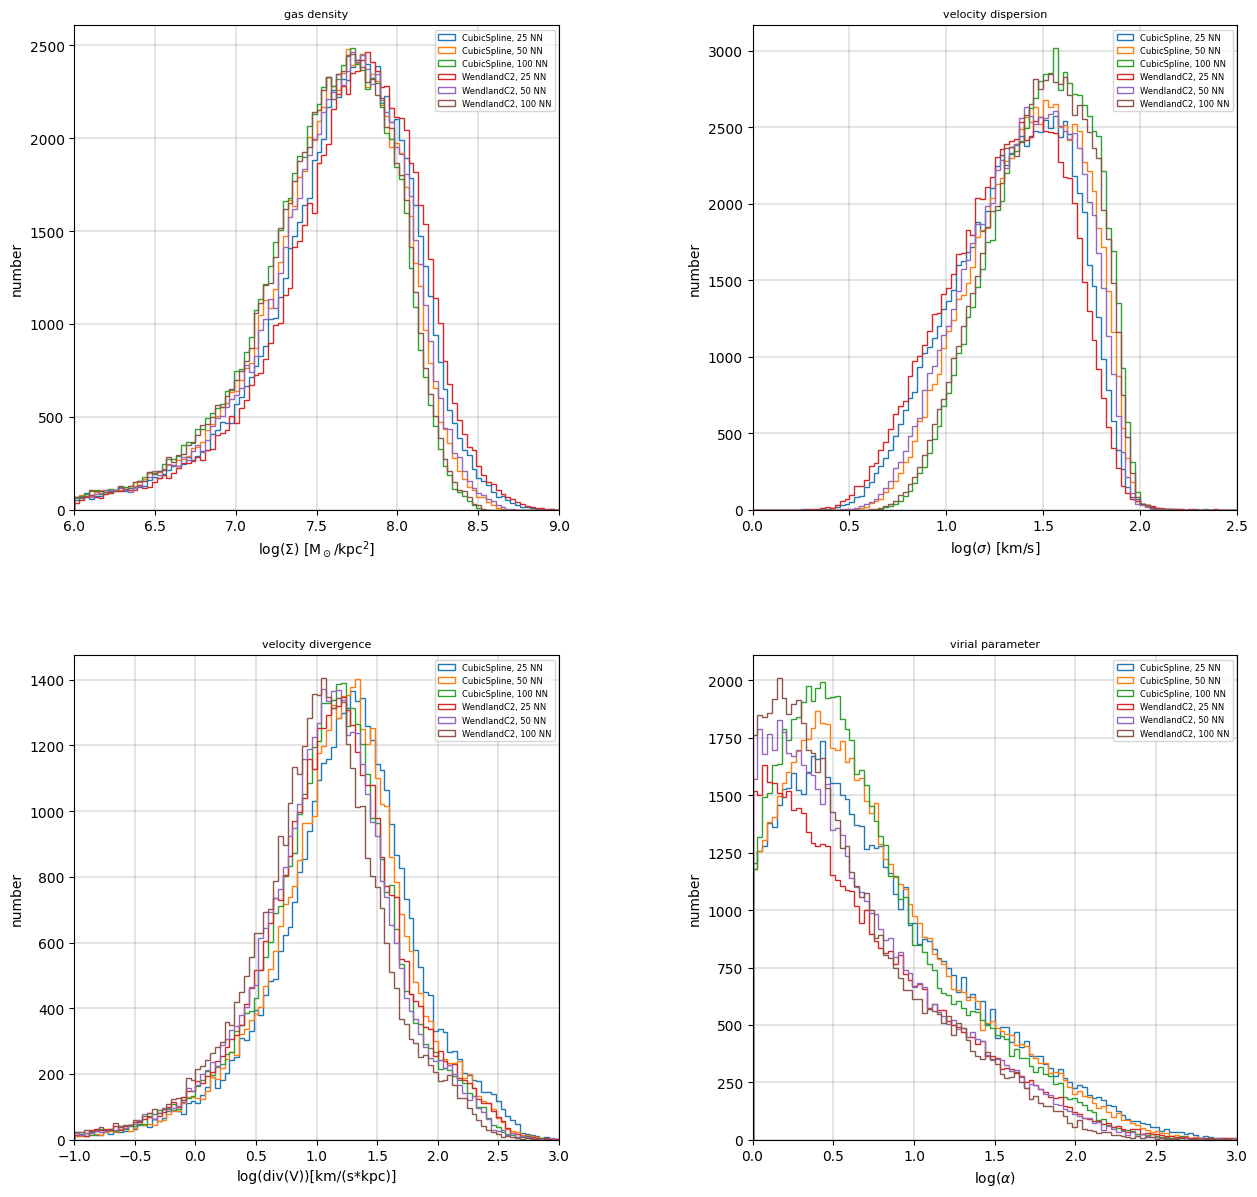

In [33]:
rho_list = [np.log10(rho_CS_25), np.log10(rho_CS_50), np.log10(rho_CS_100), np.log10(rho_W_25), np.log10(rho_W_50), np.log10(rho_W_100)]
#rho_list = [rho_CS_25, rho_CS_50, rho_CS_100, rho_W_25, rho_W_50, rho_W_100]
v_disp_list = [np.log10(vdisp_CS_25), np.log10(vdisp_CS_50), np.log10(vdisp_CS_100), np.log10(vdisp_W_25), np.log10(vdisp_W_50), np.log10(vdisp_W_100)]
v_div_list = [np.log10(vdiv_CS_25), np.log10(vdiv_CS_50), np.log10(vdiv_CS_100), np.log10(vdiv_W_25), np.log10(vdiv_W_50), np.log10(vdiv_W_100)]
alpha_2_list = [np.log10(alpha2_CS_25), np.log10(alpha2_CS_50), np.log10(alpha2_CS_100), np.log10(alpha2_W_25), np.log10(alpha2_W_50), np.log10(alpha2_W_100)]
key_list = [rho_list, v_disp_list, v_div_list, alpha_4_list]
range_list = [(6, 9), (0, 2.5), (-1, 3), (0, 3)]
#nn = [25, 50, 100]
title = ['gas density', 'velocity dispersion', 'velocity divergence', 'virial parameter (Hopkins)']
unit = [r'log($\Sigma$) [M$_\odot$/kpc$^2$]', r'log($\sigma$) [km/s]', 'log(div(V))[km/(s*kpc)]', 'log('+r'$\alpha$'+')']
label = ['CubicSpline, 25 NN', 'CubicSpline, 50 NN', 'CubicSpline, 100 NN', 'WendlandC2, 25 NN', 'WendlandC2, 50 NN', 'WendlandC2, 100 NN']
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(4):
    ax = fig.add_subplot(gs0[n])
    for i in range(6):
        ax.hist(key_list[n][i], bins = 100, label = label[i], range = range_list[n], histtype = 'step')
        
    ax.set_title(title[n], wrap = True, fontsize = 8)
    ax.set_xlabel(unit[n])
    ax.set_ylabel('number')
    ax.set_xlim(range_list[n])
    ax.set_aspect(1./ax.get_data_ratio())
    ax.grid(linewidth = 0.3, color = 'grey')
    ax.legend(fontsize = 6)

/tmp/ipykernel_27228/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass


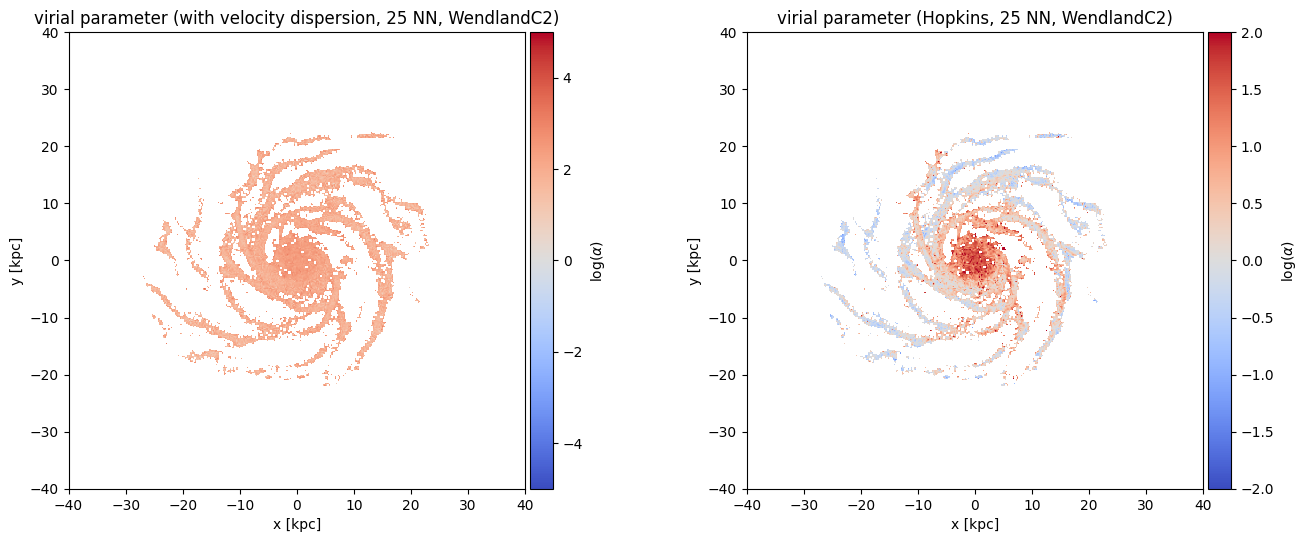

In [72]:
title = ['(Kernel, 25 NN, WendlandC2)', '(sph particle, 25 NN, WendlandC2)', '(with velocity dispersion, 25 NN, WendlandC2)', '(Hopkins, 25 NN, WendlandC2)']
alpha = [alpha_W_25, alpha2_W_25, alpha3_W_25, alpha4_W_25]
vmin_list = [-5, -5, -5, -2]
vmax_list = [5, 5, 5, 2]
fig = plt.figure(figsize = (15, 15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(2,4):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = vmin_list[n], vmax = vmax_list[n])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n], wrap = True, fontsize = 8)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.show()

/tmp/ipykernel_27228/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass


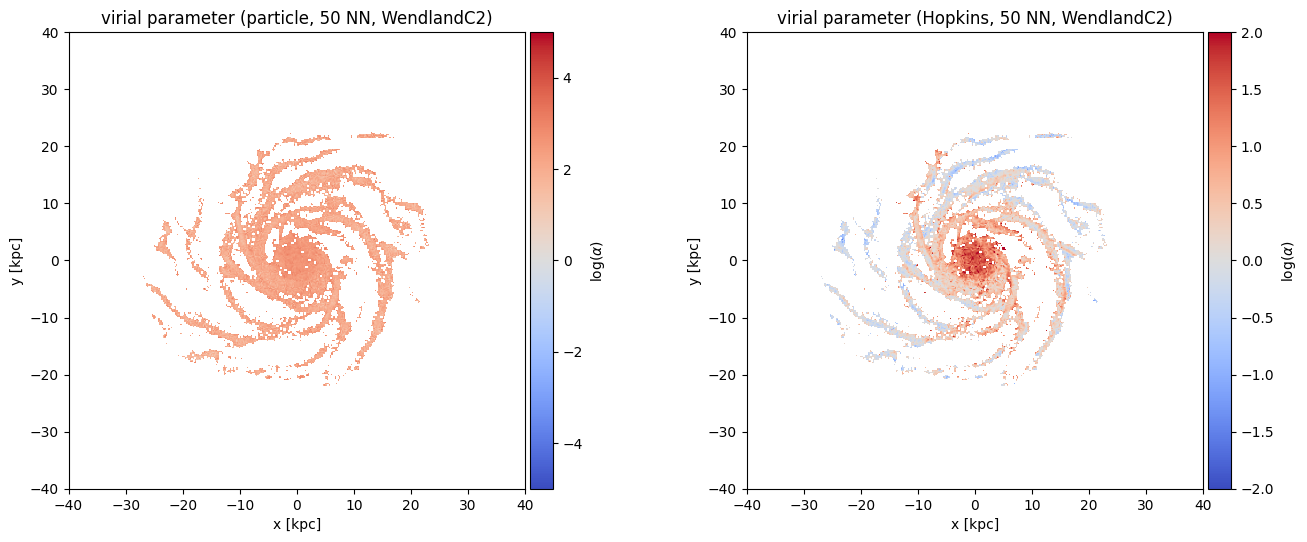

In [73]:
title = ['(Kernel, 50 NN, WendlandC2)', '(sph particle, 50 NN, WendlandC2)', '(with velocity dispersion, 50 NN, WendlandC2)', '(Hopkins, 50 NN, WendlandC2)']
alpha = [alpha_W_50, alpha2_W_50, alpha3_W_50, alpha4_W_50]
vmin_list = [-5, -5, -5, -2]
vmax_list = [5, 5, 5, 2]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(2,4):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = vmin_list[n], vmax = vmax_list[n])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n], wrap = True, fontsize = 8)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect(1./ax.get_data_ratio())

plt.show()

/tmp/ipykernel_27228/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass


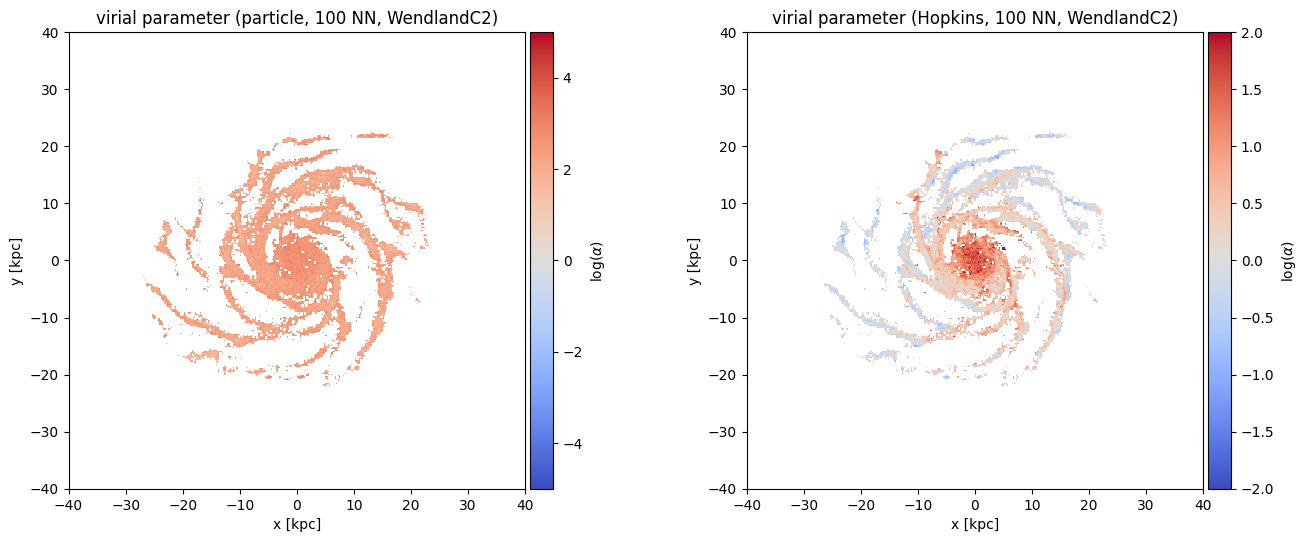

In [74]:
title = ['(Kernel, 100 NN, WendlandC2)', '(sph particle, 100 NN, WendlandC2)', '(with velocity dispersion, 100 NN, WendlandC2)', '(Hopkins, 100 NN, WendlandC2)']
alpha = [alpha_W_100, alpha2_W_100, alpha3_W_100, alpha4_W_100]
vmin_list = [-5, -5, -5, -2]
vmax_list = [5, 5, 5, 2]
fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(2, 4):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = vmin_list[n], vmax = vmax_list[n])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n], wrap = True, fontsize = 8)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect(1./ax.get_data_ratio())

plt.show()

/tmp/ipykernel_27228/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass


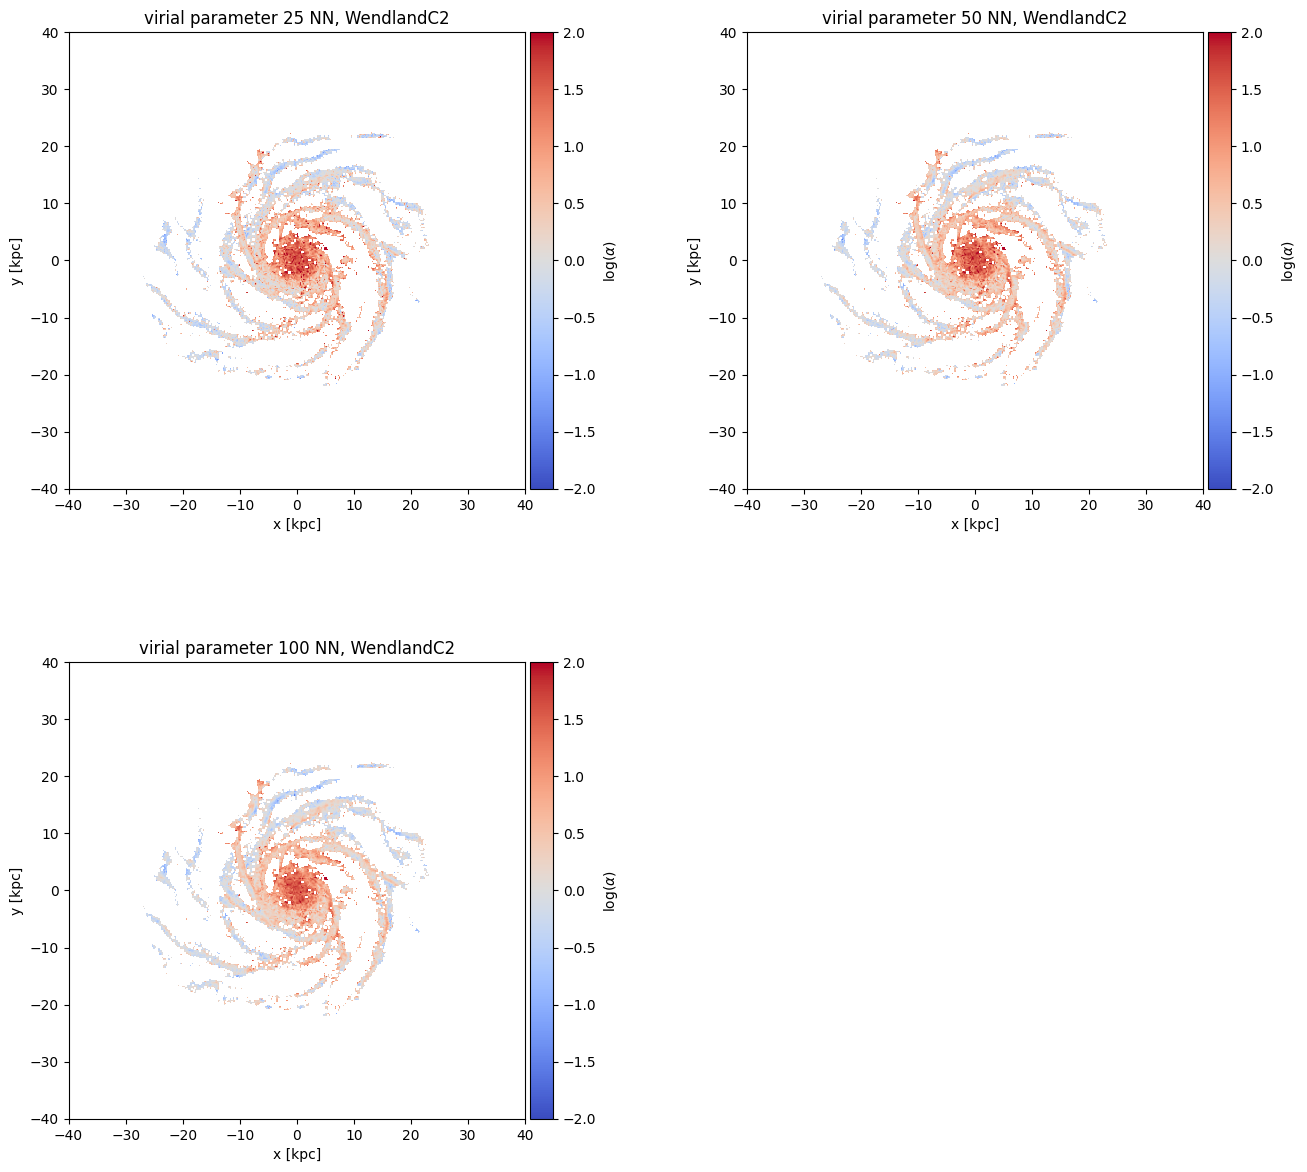

In [75]:
title = ['25 NN, WendlandC2', '50 NN, WendlandC2', '100 NN, WendlandC2']
alpha = [alpha4_W_25, alpha4_W_50, alpha4_W_100]

fig = plt.figure(figsize = (15,15))
gs0 = gd.GridSpec(2, 2, figure=fig, wspace = 0.4)

for n in range(3):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, alpha[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = -2, vmax = 2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\alpha$)')
    ax.set_title('virial parameter ' + title[n], wrap = True, fontsize = 8)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect(1./ax.get_data_ratio())

plt.show()

/tmp/ipykernel_30276/17126251.py:30: RuntimeWarning: invalid value encountered in divide
  return hist/mass
/tmp/ipykernel_30276/424556266.py:10: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(mw_hist(gal.g, eff[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = vmin_list[n], vmax = vmax_list[n])


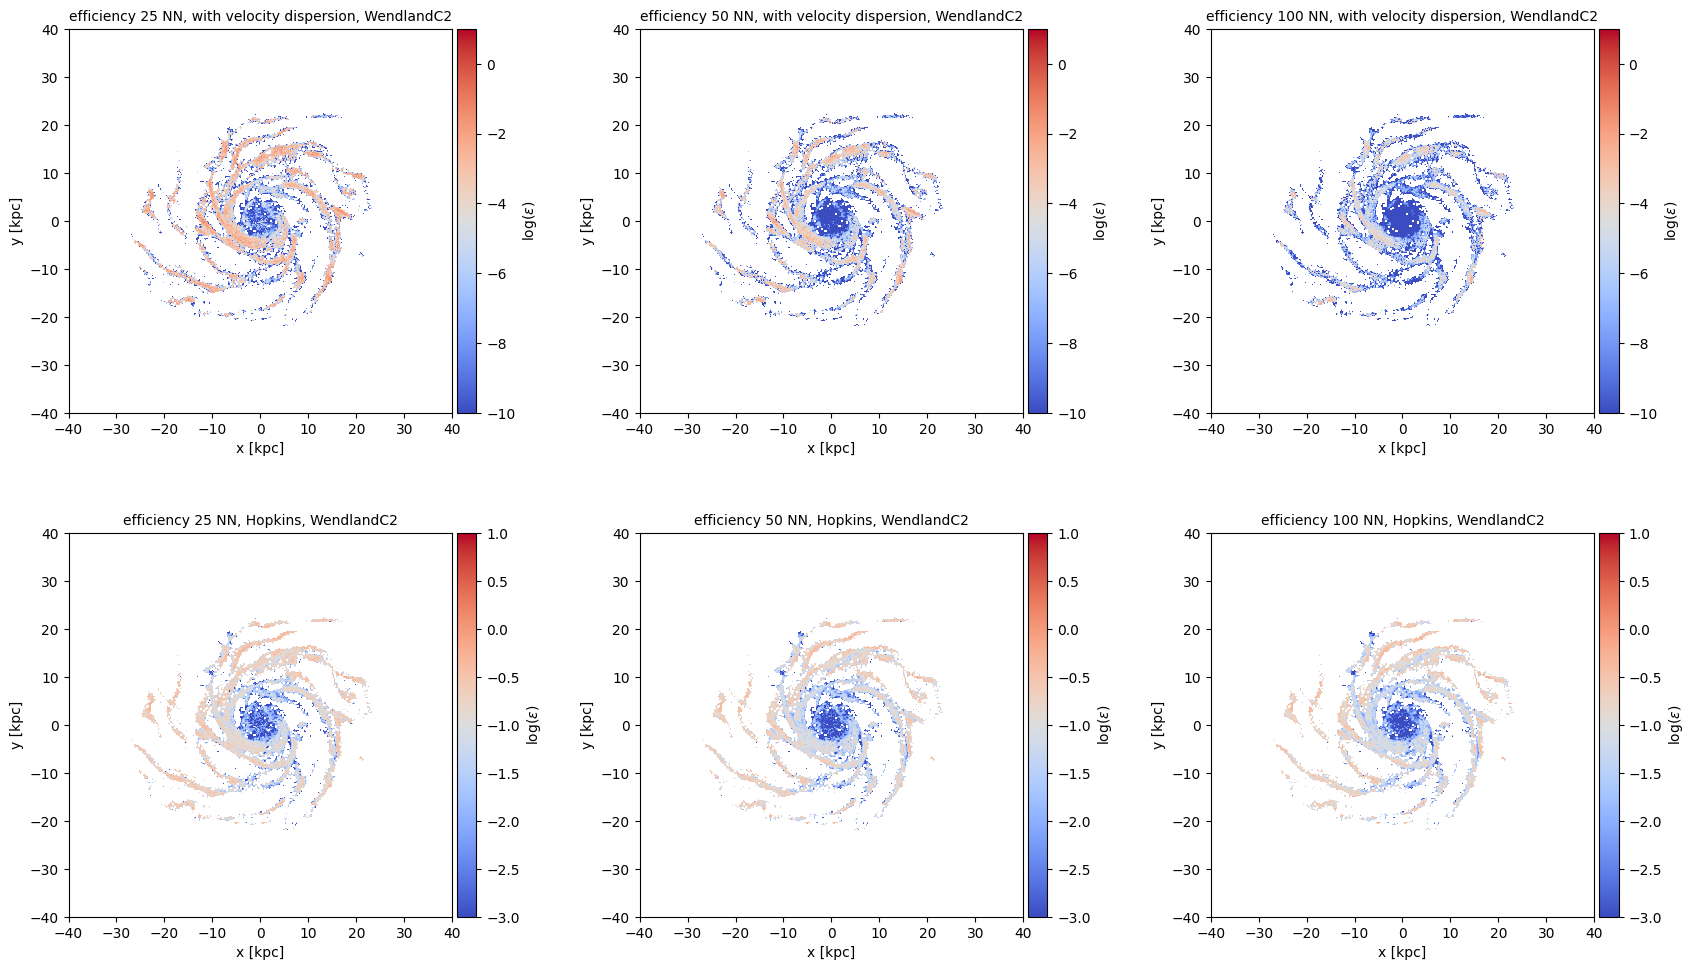

In [54]:
title = ['25 NN, with velocity dispersion, WendlandC2', '50 NN, with velocity dispersion, WendlandC2', '100 NN, with velocity dispersion, WendlandC2', '25 NN, Hopkins, WendlandC2', '50 NN, Hopkins, WendlandC2', '100 NN, Hopkins, WendlandC2']
eff = [eff_vdisp_W_25, eff_vdisp_W_50, eff_vdisp_W_100, eff_Hop_W_25, eff_Hop_W_50, eff_Hop_W_100]
fig = plt.figure(figsize = (20,12))
gs0 = gd.GridSpec(2, 3, figure=fig, wspace = 0.4)
vmin_list = [-10, -10, -10, -3, -3, -3]
vmax_list = [1, 1, 1, 1, 1, 1]

for n in range(6):
    ax = fig.add_subplot(gs0[n])
    im = ax.imshow(np.log10(mw_hist(gal.g, eff[n], 500)), extent=(-50,50,-50,50), cmap='coolwarm', vmin = vmin_list[n], vmax = vmax_list[n])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label = r'log($\epsilon$)')
    ax.set_title('efficiency ' + title[n], wrap = True, fontsize = 10)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect(1./ax.get_data_ratio())

plt.show()

In [24]:
# densities
#g_hist, g_xbins, g_ybins = np.histogram2d(gal.g['x'],gal.g['y'],weights=gal.g['rho'], bins=500, range=((-50,50),(-50,50)))
#s_hist, s_xbins, s_ybins = np.histogram2d(gal.s['x'],gal.s['y'],weights=gal.s['rho'], bins=500, range=((-50,50),(-50,50)))
g_hist, g_xedge, g_yedge, g_bin  = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['rho'], statistic = 'mean', bins = 500)
s_hist, s_xedge, s_yedge, s_bin = stats.binned_statistic_2d(gal.s['x'],gal.s['y'], gal.s['rho'], statistic = 'mean', bins = 500)

alpha_hist, a_xbins, a_ybins, a_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['alpha'], statistic = 'mean', bins = 200)
eff_hist, e_xedges, e_yedges, e_bin = stats.binned_statistic_2d(gal_low_alpha['x'],gal_low_alpha['y'], gal_low_alpha['efficiency'], statistic = 'mean', bins = 200)




In [ ]:
pg1 = pynbody.analysis.profile.Profile(gal.g, min = 0.01, max = 50, type = 'equaln')
ps1 = pynbody.analysis.profile.Profile(gal.s, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha = pynbody.analysis.profile.Profile(gal_low_alpha, min = 0.01, max = 50, type = 'equaln')
pg_low_alpha_4 = pynbody.analysis.profile.Profile(gal_low_alpha_4, min = 0.01, max = 50, type = 'equaln')

In [ ]:

fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot(121)
im1 = ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax1.imshow(g_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

ax2 = plt.subplot(122)
im2 = ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
ax2.imshow(s_hist, cmap='Blues', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = '$\Sigma$ [M$_\odot$/kpc$^2$]')
ax2.set_title('star density')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
#ax1.xlim(-30, 30)
#ax1.ylim(-30,30)

fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (15,10))

ax1 = plt.subplot(231)
im1 = ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 6.5)
ax1.imshow(np.log10(g_hist), cmap='RdYlBu_r', extent=(-50,50,-50,50), vmin = 6.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = 'log($\Sigma$) [M$_\odot$/kpc$^2$]')
ax1.set_title('gas density')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
ax1.set_xlim(-20, 20)
ax1.set_ylim(-20,20)

ax2 = plt.subplot(232)
im2 = ax2.imshow(np.log10(mw_hist(gal.g,'temp',500)), cmap='seismic', extent=(-50,50,-50,50))
ax2.imshow(mw_hist(gal.g,'temp',500), cmap='seismic', extent=(-50,50,-50,50), norm = colors.LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label = 'T [K]')
ax2.set_title('gas temperature')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('y [kpc]')
ax2.set_xlim(-20, 20)
ax2.set_ylim(-20,20)

ax3 = plt.subplot(233)
im3 = ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15, vmax = 70)
ax3.imshow(mw_hist(gal.g,'v_disp',500), cmap='gnuplot2', extent=(-50,50,-50,50), vmin = 15,vmax = 70)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label =r'$\sigma$ [km/s]')
ax3.set_title('Velocity dispersion')
ax3.set_xlabel('x [kpc]')
ax3.set_ylabel('y [kpc]')
ax3.set_aspect('equal')
ax3.set_xlim(-20, 20)
ax3.set_ylim(-20,20)

ax4 = plt.subplot(234)
im4 = ax4.imshow(mw_hist(gal_low_alpha,'alpha_4',500), extent=(-50,50,-50,50), cmap='bone', norm = colors.LogNorm())
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label = r'$\alpha$')
ax4.set_title('Virial parameter')
ax4.set_xlabel('x [kpc]')
ax4.set_ylabel('y [kpc]')
ax4.set_aspect('equal')
ax4.set_xlim(-20, 20)
ax4.set_ylim(-20, 20)

ax5 = plt.subplot(235)
im5 = ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
ax5.imshow(mw_hist(gal_low_alpha,'efficiency',500), extent=(-50,50,-50,50), cmap='gist_earth_r', norm = colors.LogNorm())
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical', label = r'$\epsilon_{ff}$')
ax5.set_title('Efficiency')
ax5.set_xlabel('x [kpc]')
ax5.set_ylabel('y [kpc]')
ax5.set_aspect('equal')
ax5.set_xlim(-20, 20)
ax5.set_ylim(-20,20)


fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))

ax1 = plt.subplot(231)
ax1.plot(pg1['rbins'],pg1['density'])
ax1.semilogy()
ax1.set_title('density')
ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('$\Sigma$ [M$_\odot$/kpc$^2$]')
ax1.grid(linewidth = 0.5)
ax1.set_aspect(1./ax1.get_data_ratio())
#ax1.set_xlim(0,50)
#ax1.set_aspect('equal')

ax2 = plt.subplot(232)
ax2.plot(pg1['rbins'], pg1['temp'])
ax2.set_title('gas temperature')
ax2.set_xlabel('R [kpc]')
ax2.set_ylabel('T [K]')
ax2.grid(linewidth = 0.5)
ax2.set_aspect(1./ax2.get_data_ratio())
#ax2.set_xlim(0,50)
#ax2.set_aspect('equal')

ax3 = plt.subplot(233)
ax3.plot(pg1['rbins'], pg1['v_disp'])
ax3.set_title('velocity dispersion')
ax3.set_xlabel('R [kpc]')
ax3.set_ylabel(r'$\sigma$ [km/s]')
ax3.grid(linewidth = 0.5)
ax3.set_aspect(1./ax3.get_data_ratio())
#ax3.set_xlim(0,50)
#ax3.set_aspect('equal')

ax4 = plt.subplot(234)
ax4.plot(pg_low_alpha['rbins'], pg_low_alpha_4['alpha_4'])
ax4.set_title('virial parameter')
ax4.set_xlabel('R [kpc]')
ax4.set_ylabel(r'$\alpha$')
ax4.grid(linewidth = 0.5)
ax4.set_aspect(1./ax4.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')

ax5 = plt.subplot(235)
ax5.plot(pg_low_alpha['r'], pg_low_alpha['efficiency'])
ax5.set_title('efficiency')
ax5.set_xlabel('R [kpc]')
ax5.set_ylabel(r'$\epsilon_{ff}$')
ax5.grid(linewidth = 0.5)
ax5.set_aspect(1./ax5.get_data_ratio())
#ax4.set_xlim(0,50)
#ax4.set_aspect('equal')


fig.tight_layout()
plt.show()

In [ ]:
plt.hist2d(gal.g['x'], gal.g['y'], cmap = 'gist_earth', bins = 500)
axes = plt.gca()
axes.set_aspect(1./axes.get_data_ratio())
plt.colorbar()
plt.xlim(-50,50)
plt.ylim(-50,50)


In [ ]:
#2d histogramme von der anzahl -> boxgröße bestimmen, so dass wir 50 teilchen pro box haben-> daraus die größen bestimmen und damit alpha plotten
print(np.mean(hist[hist>0]))

dx = (gal.g['x'].max()-gal.g['x'].min())/250
dy = (gal.g['y'].max()-gal.g['y'].min())/250
dz = gal.g['z'].max()-gal.g['z'].min()
R = 1/2*np.sqrt(dx**2+dy**2+dz**2)

gal.g['velo2'] = gal.g['v_disp']
gal.g['velo2'] = gal.g['v2']**(1/2)
gal.g['velo2']

mass_hist, mass_xedge, mass_yedge, mass_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['mass'], statistic = 'sum', bins=250)
vdisp_hist, vdisp_xedge, vdisp_yedge, vdisp_bin = stats.binned_statistic_2d(gal.g['x'],gal.g['y'], gal.g['velo2'], statistic = 'std', bins=250)

a_hist = np.zeros((250,250))
for i in range(250):
    for j in range(250):
        a_hist[i][j] = 5*(vdisp_hist[i][j]*units.km*units.s**-1)**2*R/(3*constants.G*units.m**3*units.kg**-1*units.s**-2*mass_hist[i][j]*units.Msol)

In [ ]:
def binstat(fam, key, b):
    stat, edges, num = stats.binned_statistic(fam['r'], fam[key]*fam['mass'], statistic = sum, bins = b)
    stat_mass, edges_mass, num_mass = stats.binned_statistic(fam['r'], fam['mass'], statistic = sum, bins = b)
    return stat/stat_mass, edges[:-1]